# 3 Preprocessing and Training<a id='3_Preprocessing_and_Training'></a>

 <b>3.1 Introduction <b/>

In this notebook we will build machine learning models and bench mark these models against our average value using different scoring methods such as mean absolute error and mean squared error. We will then examine wether we still need to collect more data and finally select our best model so we could proceed with modeling.

 <b>3.2 Import<b/>

Import relevant python packages

In [188]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

 <b>3.3 Load Data<b/>

Load Combined cycle data set

In [2]:
df = pd.read_excel('combined_cycle.xlsx')

In [3]:
print(df.head())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


 <b>3.4 Train/Test Split<b/>

Subdivide the data set as test and training sets.

In [4]:
len(df) * .7, len(df) * .3

(6697.599999999999, 2870.4)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='PE'), 
                                                    df.PE, test_size=0.3, 
                                                    random_state=10)

30% of data is assigned to the training set

 <b>3.4.1 Examine Training and Test sets<b/>

In [6]:
X_train.shape, X_test.shape

((6697, 4), (2871, 4))

In [7]:
print(X_test)

         AT      V       AP     RH
5925  19.60  48.14  1013.18  68.71
4294  21.28  70.32  1011.55  88.05
7120  28.62  59.14  1016.36  53.10
6688  11.02  40.00  1015.75  74.83
7322  23.02  63.47  1012.21  80.61
...     ...    ...      ...    ...
6996  18.18  67.71  1004.50  87.26
3484  18.68  46.00  1002.20  97.17
8097  13.16  43.71  1024.44  85.68
8513  27.17  67.45  1015.67  49.03
5499  28.87  57.19  1008.09  64.29

[2871 rows x 4 columns]


In [8]:
print(X_test)

         AT      V       AP     RH
5925  19.60  48.14  1013.18  68.71
4294  21.28  70.32  1011.55  88.05
7120  28.62  59.14  1016.36  53.10
6688  11.02  40.00  1015.75  74.83
7322  23.02  63.47  1012.21  80.61
...     ...    ...      ...    ...
6996  18.18  67.71  1004.50  87.26
3484  18.68  46.00  1002.20  97.17
8097  13.16  43.71  1024.44  85.68
8513  27.17  67.45  1015.67  49.03
5499  28.87  57.19  1008.09  64.29

[2871 rows x 4 columns]


<b>3.5 Initial Model - Mean Predictor Model<b/>

Create initial model that will be used to assess the performance of minimum

In [9]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train,y_train)


DummyRegressor()

In [10]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([454.27402867, 454.27402867, 454.27402867, 454.27402867,
       454.27402867])

Since our Mean Predictor Model predicts the mean of the data set,predicting the target feature using the training data set produced the mean of training set. 

In [11]:
y_te_pred = dumb_reg.predict(X_test)

In [12]:
y_tr_pred[:5]

array([454.27402867, 454.27402867, 454.27402867, 454.27402867,
       454.27402867])

The Mean Predictor Model predicted the mean of the data training set using the test set as expected.

<b>3.6 Metrics<b/>

<b>3.6.1 R-squared, or coefficient of determination<b/>

The R-squared measures the proportion of variance in the dependent variable model that is predicted by our model.

In [13]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00031021886927429243)

<b>3.6.2 Mean Abosolute Error<b/>

In [14]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(14.775990550149276, 14.95182564212665)

The mean absolute error is the average of the absolute errors:

In [15]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(289.03822692347245, 296.4430974433076)

The mean squared error is the average of the sqaure of the errors:

<b>3.7 Linear Regression Model<b/>

<b>3.7.1 Linear Regression Pipeline<b/>

Create linear regression pipeline that will scale the features, train a model, select the k best features and calculate model performance.

In [16]:
pipe = make_pipeline(
    SelectKBest(f_regression,k='all'), 
    StandardScaler(), 
    LinearRegression()
   
)

Check pipeline parameters

In [17]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'standardscaler', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

<b>3.7.2 Linear Regression Model Hyperparemeter tuning using GridSearchCV<b/>

Define grid_params

In [18]:
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {'selectkbest__k': k}
print(k)

[1, 2, 3, 4]


Define GridSearchCV for the linear regression model

In [19]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Fit model

In [20]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(k='all',
                                                    score_func=<function f_regression at 0x000001C18921BB80>)),
                                       ('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3, 4]})

Get test scores

In [21]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]


Plot mean_cv score vs k number of features

4


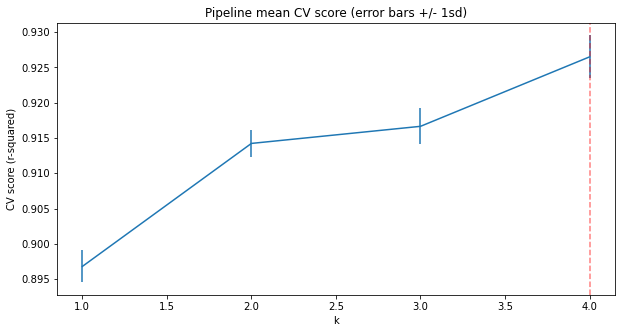

In [22]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');
print(best_k)

Including all 4 features produced the linear regression model with the highest cross-validation sccore.

Find the logical mask of the features selected.

In [23]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [24]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

AP     0.409682
RH    -2.221464
V     -3.031877
AT   -14.553435
dtype: float64

As can be see seen increasing the ambient temperature decreases the electrical energy output the most compared to the other three features.

<b>3.8 Random Forest Model<b/>

<b>3.8.1 Random Forest Model Pipeline<b/>

Create Random Forest pipeline that will scale the features, train a model and calculate model performance.

In [25]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=10)
)

<b>3.8.2 Random Forest Model Hyperparemeter tuning using GridSearchCV<b/>

In [26]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [27]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.95740334, 0.95565328, 0.95308445, 0.9581777 , 0.95483468])

In [28]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.955830690577321, 0.0018191769297832426)

In [29]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]      
}
print(n_est)
grid_params

[10, 12, 16, 20, 26, 33, 42, 54, 69, 88, 112, 143, 183, 233, 297, 379, 483, 615, 784, 1000]


{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

Define GridSearchCV for the Random Forest regression model

In [30]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Get Key params

In [86]:
rf_grid_cv.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__randomforestregressor', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__randomforestregressor__bootstrap', 'estimator__randomforestregressor__ccp_alpha', 'estimator__randomforestregressor__criterion', 'estimator__randomforestregressor__max_depth', 'estimator__randomforestregressor__max_features', 'estimator__randomforestregressor__max_leaf_nodes', 'estimator__randomforestregressor__max_samples', 'estimator__randomforestregressor__min_impurity_decrease', 'estimator__randomforestregressor__min_impurity_split', 'estimator__randomforestregressor__min_samples_leaf', 'estimator__randomforestregressor__min_samples_split', 'estimator__randomforestregressor__min_weight_fraction_leaf', 'estimator__randomforestregressor__n_estimators', 'estimator__randomforestregressor__n_jobs', 'estima

Fit data to random forest model

In [31]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

Find the parameters of the best random forest model

In [32]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'standardscaler': StandardScaler()}

In [ ]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

Find mean cross validation score

In [34]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.9562476875678882, 0.001974680534877313)

Just like in the case of the Linear Regression the ambient temperature is the most important feature. 

<b>3.9 AdaBoost Model<b/>

Create AdaBoost pipeline

In [48]:
AdaBoost_pipe = make_pipeline(
    StandardScaler(),
    AdaBoostRegressor(random_state=10)
)

Find Adaboost pipeline parameters

In [117]:
AdaBoost_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'gradientboostingregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estimators', 'gradientboostingregressor__n_iter_no_change', 'gradientboostingregressor__presort', 'gradientboostingregressor__random_state', 'gradientboostingregressor__subsample', 'gradientbo

In [40]:
AdaBoost_default_cv_results = cross_validate(AdaBoost_pipe, X_train, y_train, cv=5)

In [41]:
AdaBoost_default_cv_scores = AdaBoost_default_cv_results['test_score']

In [42]:
AdaBoost_default_cv_scores

array([0.89507182, 0.90572061, 0.90307088, 0.89803861, 0.89655534])

In [43]:
np.mean(AdaBoost_default_cv_scores), np.std(AdaBoost_default_cv_scores)

(0.8996914514843182, 0.004041764491950771)

In [76]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'n_estimators': n_est, 
        'estimator__adaboostregressor__loss' : ['linear', 'square', 'exponential'],
        'estimator__adaboostregressor__learning_rate' : [0.01,0.05,0.1,0.3,1],
        
}

In [100]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = { 
        'adaboostregressor__n_estimators' : n_est,
        'adaboostregressor__loss' : ['linear', 'square', 'exponential'],
        'adaboostregressor__learning_rate' : [0.01,0.05,0.1,0.3,1],
        
}

In [101]:
AdaBoost_grid_cv = GridSearchCV(AdaBoost_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [102]:
print(AdaBoost_grid_cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('adaboostregressor',
                                        AdaBoostRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'adaboostregressor__learning_rate': [0.01, 0.05, 0.1,
                                                              0.3, 1],
                         'adaboostregressor__loss': ['linear', 'square',
                                                     'exponential'],
                         'adaboostregressor__n_estimators': [10, 12, 16, 20, 26,
                                                             33, 42, 54, 69, 88,
                                                             112, 143, 183, 233,
                                                             297, 379, 483, 615,
                                                             784, 1000]})


Find AdaBoost regressor parameters

In [103]:
AdaBoost_grid_cv.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__adaboostregressor', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__adaboostregressor__base_estimator', 'estimator__adaboostregressor__learning_rate', 'estimator__adaboostregressor__loss', 'estimator__adaboostregressor__n_estimators', 'estimator__adaboostregressor__random_state', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

Fit data to Adaboost regressor

In [104]:
AdaBoost_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('adaboostregressor',
                                        AdaBoostRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'adaboostregressor__learning_rate': [0.01, 0.05, 0.1,
                                                              0.3, 1],
                         'adaboostregressor__loss': ['linear', 'square',
                                                     'exponential'],
                         'adaboostregressor__n_estimators': [10, 12, 16, 20, 26,
                                                             33, 42, 54, 69, 88,
                                                             112, 143, 183, 233,
                                                             297, 379, 483, 615,
                                                             784, 1000]})

Find the parameters of the best AdaBoost Model

In [105]:
AdaBoost_grid_cv.best_params_

{'adaboostregressor__learning_rate': 0.3,
 'adaboostregressor__loss': 'exponential',
 'adaboostregressor__n_estimators': 16}

Find the cross validation scores

In [106]:
AdaBoost_best_cv_results = cross_validate(AdaBoost_grid_cv.best_estimator_, X_train, y_train, cv=5)
AdaBoost_best_scores = AdaBoost_best_cv_results['test_score']
AdaBoost_best_scores

array([0.92459143, 0.91639913, 0.91925675, 0.92069659, 0.91801706])

Find the mean of cross validdation scores of the AdaBoost models

In [107]:
np.mean(AdaBoost_best_scores), np.std(AdaBoost_best_scores)

(0.919792190688705, 0.002785724112740921)

<b>3.10 GradientBoost Model<b/>

Build GradientBoost Model

In [130]:
GradientBoost_pipe = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(random_state=10)
)

Find the parameters of the GradientBoost Model

In [138]:
GradientBoost_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'gradientboostingregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'gradientboostingregressor__alpha', 'gradientboostingregressor__ccp_alpha', 'gradientboostingregressor__criterion', 'gradientboostingregressor__init', 'gradientboostingregressor__learning_rate', 'gradientboostingregressor__loss', 'gradientboostingregressor__max_depth', 'gradientboostingregressor__max_features', 'gradientboostingregressor__max_leaf_nodes', 'gradientboostingregressor__min_impurity_decrease', 'gradientboostingregressor__min_impurity_split', 'gradientboostingregressor__min_samples_leaf', 'gradientboostingregressor__min_samples_split', 'gradientboostingregressor__min_weight_fraction_leaf', 'gradientboostingregressor__n_estimators', 'gradientboostingregressor__n_iter_no_change', 'gradientboostingregressor__presort', 'gradientboostingregressor__random_state', 'gradientboostingregressor__subsample', 'gradientbo

Cross Validate default Gradient Boost model

In [158]:
GradientBoost_default_cv_results = cross_validate(GradientBoost_pipe, X_train, y_train, cv=5)

Find the mean of cross validdation scores of the GradientBoost models

In [159]:
GradientBoost_default_cv_scores = GradientBoost_default_cv_results['test_score']

In [160]:
GradientBoost_default_cv_scores

array([0.94865794, 0.94604822, 0.94232808, 0.94804518, 0.94310548])

In [161]:
np.mean(GradientBoost_default_cv_scores), np.std(GradientBoost_default_cv_scores)

(0.9456369806047104, 0.002547627560777183)

In [162]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'gradientboostingregressor__n_estimators': n_est, 
        'gradientboostingregressor__loss' : ['ls', 'lad', 'huber', 'quantile'],
        'gradientboostingregressor__learning_rate' : [0.01,0.05,0.1,0.3,1],
        
}

In [163]:
GradientBoost_grid_cv = GridSearchCV(GradientBoost_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Find parameters of the GradientBoost pipeline

In [164]:
GradientBoost_grid_cv .get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__gradientboostingregressor', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__gradientboostingregressor__alpha', 'estimator__gradientboostingregressor__ccp_alpha', 'estimator__gradientboostingregressor__criterion', 'estimator__gradientboostingregressor__init', 'estimator__gradientboostingregressor__learning_rate', 'estimator__gradientboostingregressor__loss', 'estimator__gradientboostingregressor__max_depth', 'estimator__gradientboostingregressor__max_features', 'estimator__gradientboostingregressor__max_leaf_nodes', 'estimator__gradientboostingregressor__min_impurity_decrease', 'estimator__gradientboostingregressor__min_impurity_split', 'estimator__gradientboostingregressor__min_samples_leaf', 'estimator__gradientboostingregressor__min_samples_split', 'estimator__gradientboost

Fit training data to the GradientBoost grid

In [165]:
GradientBoost_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.3, 1],
                         'gradientboostingregressor__loss': ['ls', 'lad',
                                                             'huber',
                                                             'quantile'],
                         'gradientboostingregressor__n_estimators': [10, 12, 16,
                                                                     20, 26, 33,
                                                                     42, 54, 69,
                           

Find the parameters of the model with the best cross validation score.

In [166]:
GradientBoost_grid_cv.best_params_

{'gradientboostingregressor__learning_rate': 0.3,
 'gradientboostingregressor__loss': 'huber',
 'gradientboostingregressor__n_estimators': 784}

Find the cross validation scores

In [183]:
GradientBoost_best_cv_results = cross_validate(GradientBoost_grid_cv.best_estimator_, X_train, y_train, cv=5)
GradientBoost_best_scores = GradientBoost_best_cv_results['test_score']
GradientBoost_best_scores

array([0.96162663, 0.96105984, 0.9581212 , 0.9659747 , 0.95853449])

Find the mean of the cross validation scores

In [168]:
np.mean(GradientBoost_best_scores), np.std(GradientBoost_best_scores)

(0.9610633725183721, 0.002810338863055687)

<b>3.11 Multi-layer Perceptron Model<b/>

Create Multi-layer Perceptron pipeline

In [ ]:
MLPRegressor_pipe = make_pipeline(
    StandardScaler(),
    MLPRegressor(random_state=10)
)

Get parameter keys

In [248]:
MLPRegressor_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'mlpregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'mlpregressor__activation', 'mlpregressor__alpha', 'mlpregressor__batch_size', 'mlpregressor__beta_1', 'mlpregressor__beta_2', 'mlpregressor__early_stopping', 'mlpregressor__epsilon', 'mlpregressor__hidden_layer_sizes', 'mlpregressor__learning_rate', 'mlpregressor__learning_rate_init', 'mlpregressor__max_fun', 'mlpregressor__max_iter', 'mlpregressor__momentum', 'mlpregressor__n_iter_no_change', 'mlpregressor__nesterovs_momentum', 'mlpregressor__power_t', 'mlpregressor__random_state', 'mlpregressor__shuffle', 'mlpregressor__solver', 'mlpregressor__tol', 'mlpregressor__validation_fraction', 'mlpregressor__verbose', 'mlpregressor__warm_start'])

Cross validate default MLP model

In [171]:
MLP_default_cv_results = cross_validate(MLPRegressor_pipe, X_train, y_train, cv=5)

C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Find cross validation scores

In [172]:
MLP_default_cv_scores = MLP_default_cv_results['test_score']

In [173]:
MLP_default_cv_scores

array([0.74309777, 0.71255366, 0.72517556, 0.67041767, 0.67150843])

Find the mean of the validation scores

In [174]:
np.mean(MLP_default_cv_scores), np.std(MLP_default_cv_scores)

(0.7045506207958926, 0.029093520210813437)

Define paramaeters for the MLP regressor

In [175]:
hidden_layers = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'mlpregressor__hidden_layer_sizes': hidden_layers,
        'mlpregressor__activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'mlpregressor__solver' : ['lbfgs', 'sgd', 'adam'],
        'mlpregressor__learning_rate' : ['constant', 'invscaling', 'adaptive'],        
}

Perform grid search

In [178]:
MLP_grid_cv = GridSearchCV(MLPRegressor_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Get parameter keys for the MLP

In [180]:
MLP_grid_cv.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__mlpregressor', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__mlpregressor__activation', 'estimator__mlpregressor__alpha', 'estimator__mlpregressor__batch_size', 'estimator__mlpregressor__beta_1', 'estimator__mlpregressor__beta_2', 'estimator__mlpregressor__early_stopping', 'estimator__mlpregressor__epsilon', 'estimator__mlpregressor__hidden_layer_sizes', 'estimator__mlpregressor__learning_rate', 'estimator__mlpregressor__learning_rate_init', 'estimator__mlpregressor__max_fun', 'estimator__mlpregressor__max_iter', 'estimator__mlpregressor__momentum', 'estimator__mlpregressor__n_iter_no_change', 'estimator__mlpregressor__nesterovs_momentum', 'estimator__mlpregressor__power_t', 'estimator__mlpregressor__random_state', 'estimator__mlpregressor__shuffle', 'estimator__mlpregresso

Train MLP model with data

In [181]:
MLP_grid_cv.fit(X_train, y_train)

C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('mlpregressor',
                                        MLPRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'mlpregressor__activation': ['identity', 'logistic',
                                                      'tanh', 'relu'],
                         'mlpregressor__hidden_layer_sizes': [10, 12, 16, 20,
                                                              26, 33, 42, 54,
                                                              69, 88, 112, 143,
                                                              183, 233, 297,
                                                              379, 483, 615,
                                                              784, 1000],
                         'mlpregressor__learning_rate': ['constant',
                                                         'invscaling

Find parameters of the MLP model with the best cv score

In [182]:
MLP_grid_cv.best_params_

{'mlpregressor__activation': 'tanh',
 'mlpregressor__hidden_layer_sizes': 297,
 'mlpregressor__learning_rate': 'constant',
 'mlpregressor__solver': 'lbfgs'}

In [184]:
MLP_best_cv_results = cross_validate(MLP_grid_cv.best_estimator_, X_train, y_train, cv=5)
MLP_best_scores = MLP_best_cv_results['test_score']
MLP_best_scores

C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\ferna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

array([0.94362647, 0.94288095, 0.93581938, 0.94448544, 0.93924712])

In [185]:
np.mean(MLP_best_scores), np.std(MLP_best_scores)

(0.9412118722200015, 0.0032333130475176485)

<b>3.12 XGBoost Model<b/>

Build XGBoost pipeline

In [197]:
XGBoost_pipe = make_pipeline(
    StandardScaler(),
    XGBRegressor(random_state=10)
)

Find parameter keys

In [198]:
XGBoost_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'xgbregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'xgbregressor__objective', 'xgbregressor__base_score', 'xgbregressor__booster', 'xgbregressor__colsample_bylevel', 'xgbregressor__colsample_bynode', 'xgbregressor__colsample_bytree', 'xgbregressor__gamma', 'xgbregressor__gpu_id', 'xgbregressor__importance_type', 'xgbregressor__interaction_constraints', 'xgbregressor__learning_rate', 'xgbregressor__max_delta_step', 'xgbregressor__max_depth', 'xgbregressor__min_child_weight', 'xgbregressor__missing', 'xgbregressor__monotone_constraints', 'xgbregressor__n_estimators', 'xgbregressor__n_jobs', 'xgbregressor__num_parallel_tree', 'xgbregressor__random_state', 'xgbregressor__reg_alpha', 'xgbregressor__reg_lambda', 'xgbregressor__scale_pos_weight', 'xgbregressor__subsample', 'xgbregressor__tree_method', 'xgbregressor__validate_parameters', 'xgbregressor__verbosity'])

Cross validate default XGBoost model

In [199]:
XGBoost_default_cv_results = cross_validate(XGboost_pipe, X_train, y_train, cv=5)

In [200]:
XGBoost_default_cv_scores = XGBoost_default_cv_results['test_score']

Find mean score

In [201]:
XGBoost_default_cv_scores

array([0.96232191, 0.96073009, 0.95823844, 0.96323448, 0.95952751])

In [202]:
np.mean(XGBoost_default_cv_scores), np.std(XGBoost_default_cv_scores)

(0.9608104856530874, 0.001812626972462727)

Build parameters for gridsearch

In [257]:
n_estimators = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'xgbregressor__n_estimators': n_estimators,
        'xgbregressor__learning_rate': [0.01,0.05,0.1,0.3,1]      
}

In [256]:
XGBoost_grid_cv = GridSearchCV(XGBoost_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

Train grid with training data

In [206]:
XGBoost_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('xgbregressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     gamma=None, gpu_id=None,
                                                     importance_type='gain',
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                            

Find the parameters of the best model

In [207]:
XGBoost_grid_cv.best_params_

{'xgbregressor__learning_rate': 0.1, 'xgbregressor__n_estimators': 1000}

Find CV scores

In [208]:
XGBoost_best_cv_results = cross_validate(XGBoost_grid_cv.best_estimator_, X_train, y_train, cv=5)
XGBoost_best_scores = XGBoost_best_cv_results['test_score']
XGBoost_best_scores

array([0.96591703, 0.96564427, 0.96205714, 0.96869388, 0.96266731])

<b>3.13 Final Model Selection<b/>

<b>3.13.1 Linear Regression Model Performance<b/>

Below is the performance of the best linear regression model.

In [212]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [213]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(3.6477442658655526, 0.03860445158092444)

In [214]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

3.587931823157423

<b>3.13.2 Random Forest Model Performance<b/>

Below is the performance of the best Random Forest model.

In [215]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [216]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(2.531033130591949, 0.047710172635825554)

In [217]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

2.3547541100661538

<b>3.13.3 AdaBoost Model Performance<b/>

Below is the performance of the best AdaBoost model.

In [252]:
AdaBoost_cv_neg_mae = cross_validate(AdaBoost_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [221]:
AdaBoost_mae_mean = np.mean(-1 * AdaBoost_cv_neg_mae['test_score'])
AdaBoost_mae_std = np.std(-1 * AdaBoost_cv_neg_mae['test_score'])
AdaBoost_mae_mean, AdaBoost_mae_std

(3.7370152139314095, 0.0934925628931005)

In [222]:
mean_absolute_error(y_test, AdaBoost_grid_cv.best_estimator_.predict(X_test))

3.7933162213562213

<b>3.13.4 GradientBoost Model<b/>

Below is the performance of the best GradientBoost model.

In [223]:
GradientBoost_cv_neg_mae = cross_validate(GradientBoost_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [224]:
GradientBoost_mae_mean = np.mean(-1 * GradientBoost_cv_neg_mae ['test_score'])
GradientBoost_mae_std = np.std(-1 * GradientBoost_cv_neg_mae ['test_score'])
GradientBoost_mae_mean, AdaBoost_mae_std

(2.342686608331177, 0.0934925628931005)

In [227]:
mean_absolute_error(y_test, GradientBoost_grid_cv.best_estimator_.predict(X_test))

2.1314906979448947

<b>3.13.5 Multi-layer Perceptron Model Performance<b/>

Below is the performance of the best Multi-layer Perceptron Model.

In [225]:
MLP_cv_neg_mae = cross_validate(MLP_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [230]:
MLP_mae_mean = np.mean(-1 * MLP_cv_neg_mae ['test_score'])
MLP_mae_std = np.std(-1 * MLP_cv_neg_mae ['test_score'])
MLP_mae_mean, MLP_mae_std

(3.1490039651751167, 0.06442704995346109)

In [231]:
mean_absolute_error(y_test, MLP_grid_cv.best_estimator_.predict(X_test))

3.0503940656780006

<b>3.13.6 XGBoost Model Performance<b/>

Below is the performance of the best XGBoost model.

In [229]:
XGBoost_cv_neg_mae = cross_validate(XGBoost_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [232]:
XGBoost_mae_mean = np.mean(-1 * XGBoost_cv_neg_mae ['test_score'])
XGBoost_mae_std = np.std(-1 * XGBoost_cv_neg_mae ['test_score'])
XGBoost_mae_mean, XGBoost_mae_std

(2.21578939964418, 0.048332385806961815)

In [249]:
mean_absolute_error(y_test, XGBoost_grid_cv.best_estimator_.predict(X_test))

2.034630282145267

The XGBoost model has the lowest Mean Absolute Error


<b>3.14 Data quantity assessment<b/>

We then assess whether we need to increase our data set by increasing the fraction of training data we introduce to the model.

In [254]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(XGboost_pipe , X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

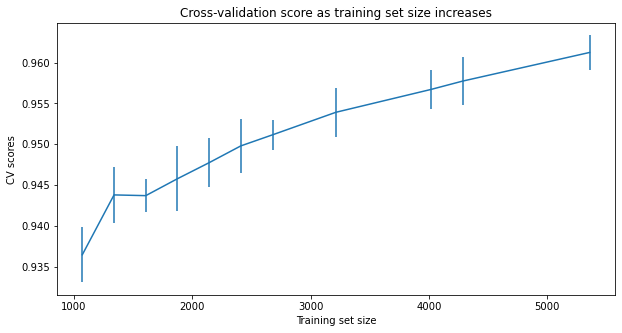

In [255]:

plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

There is no need to collect more data since the CV scores did not increase with increasing data set size.

<b>3.15 Saving Best Models<b/>

Save all best models for each algorithm

In [236]:
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'lr_grid_cv5.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [235]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'rf_grid_cv.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [237]:
best_model = AdaBoost_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'AdaBoost_grid_cv.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [238]:
best_model = GradientBoost_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'GradientBoost_grid_cv.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [239]:
best_model = MLP_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'MLP_grid_cv.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

In [240]:
best_model = XGBoost_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
skimodel_path = os.path.join(modelpath, 'XGBoost_grid_cv.pkl')
if not os.path.exists(skimodel_path):
    with open(skimodel_path, 'wb') as f:
        pickle.dump(best_model, f)

<b>3.16 Summary<b/>

The model with the highest crossvalidation score and lowest mean absolute error is our best XGBoost Model. Compared to the dummy regressor model(Mean) our XGBoost model performed significantly better. The mean absolute error of our best XGBoost Model is approximately 2 and approximately 15 for the dummy regressor. As can be seen from the feature importance analysis of  the linear regressor model the best model is theThere is also no need to collect more data because it will not increase the cross-validation score as can be seen at the tail end of the  learning_curve graph where the cv score increase given the increase of training data starts trending down. The increase in cv score is minimal compare to the cost of collecting more data.